# Map overlay of wind facility 


In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Wind Turbine Database
wind_facilities_path = "../.inputs/uswtdbSHP/uswtdb_V8_1_20250522.shp"
wind_facilities = gpd.read_file(wind_facilities_path)

print(f"Total number of wind turbines: {len(wind_facilities):,}")
print(f"Columns available: {list(wind_facilities.columns)}")
print("\nFirst few rows:")
display(wind_facilities.head())

print(f"\nCoordinate Reference System: {wind_facilities.crs}")

Total number of wind turbines: 76,051
Columns available: ['case_id', 'faa_ors', 'faa_asn', 'usgs_pr_id', 'eia_id', 't_state', 't_county', 't_fips', 'p_name', 'p_year', 'p_tnum', 'p_cap', 't_manu', 't_model', 't_cap', 't_hh', 't_rd', 't_rsa', 't_ttlh', 't_retrofit', 't_retro_yr', 't_offshore', 't_conf_atr', 't_conf_loc', 't_img_date', 't_img_src', 'xlong', 'ylat', 'geometry']

First few rows:


,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,...,t_retrofit,t_retro_yr,t_offshore,t_conf_atr,t_conf_loc,t_img_date,t_img_src,xlong,ylat,geometry
0,3119490,40-097498,2021-WTW-7911-OE,-9999,65511,OK,Ellis County,40045,25 Mile Creek,2022,...,0,-9999,0,3,3,2023/01/04,Maxar,-99.741096,36.423683,POINT (-99.7411 36.42368)
1,3124158,40-098166,2021-WTW-7917-OE,-9999,65511,OK,Ellis County,40045,25 Mile Creek,2022,...,0,-9999,0,3,3,2023/01/04,Maxar,-99.796494,36.503357,POINT (-99.79649 36.50336)
2,3123358,40-098173,2021-WTW-7871-OE,-9999,65511,OK,Ellis County,40045,25 Mile Creek,2022,...,0,-9999,0,3,3,2023/01/04,Maxar,-99.741119,36.502590,POINT (-99.74112 36.50259)
3,3123761,40-097539,2021-WTW-7888-OE,-9999,65511,OK,Ellis County,40045,25 Mile Creek,2022,...,0,-9999,0,3,3,2023/01/04,Maxar,-99.771027,36.456665,POINT (-99.77103 36.45667)
4,3124023,40-097763,2021-WTW-7894-OE,-9999,65511,OK,Ellis County,40045,25 Mile Creek,2022,...,0,-9999,0,3,3,2023/01/04,Maxar,-99.775742,36.445465,POINT (-99.77574 36.44547)



Coordinate Reference System: EPSG:4269


In [3]:
# Define WECC (Western Electricity Coordinating Council) states
wecc_states = {
    'AZ': 'Arizona',
    'CA': 'California', 
    'CO': 'Colorado',
    'ID': 'Idaho',
    'MT': 'Montana',
    'NV': 'Nevada',
    'NM': 'New Mexico',
    'OR': 'Oregon',
    'UT': 'Utah',
    'WA': 'Washington',
    'WY': 'Wyoming',
    # Also includes parts of other states, but we'll use these primary states
}

# Clean the data first - remove invalid entries
wind_clean = wind_facilities.copy()
wind_clean = wind_clean[wind_clean['t_cap'] > 0]  # Remove negative/zero capacity values
wind_clean = wind_clean[wind_clean['p_year'] > 1980]  # Remove invalid years

# Filter for WECC states
wecc_wind = wind_clean[wind_clean['t_state'].isin(wecc_states.keys())].copy()

print(f"\nWECC Wind Facilities:")
print(f"Number of turbines in WECC states: {len(wecc_wind):,}")
print(f"Total capacity in WECC: {wecc_wind['t_cap'].sum():.1f} kW")

# Show distribution by WECC state
print(f"\nWECC states distribution:")
wecc_state_stats = wecc_wind.groupby('t_state').agg({
    'case_id': 'count',
    't_cap': ['sum', 'mean']
}).round(1)
wecc_state_stats.columns = ['Turbine_Count', 'Total_Capacity_kW', 'Avg_Capacity_kW']
wecc_state_stats = wecc_state_stats.sort_values('Total_Capacity_kW', ascending=False)
print(wecc_state_stats)


WECC Wind Facilities:
Number of turbines in WECC states: 16,195
Total capacity in WECC: 31705801.0 kW

WECC states distribution:
         Turbine_Count  Total_Capacity_kW  Avg_Capacity_kW
t_state                                                   
CA                3767            6045396           1604.8
CO                2895            5383720           1859.7
NM                1866            4328750           2319.8
OR                2113            4099160           1940.0
WY                1505            3651470           2426.2
WA                1822            3395450           1863.6
MT                 944            1892220           2004.5
AZ                 424            1234860           2912.4
ID                 588            1132300           1925.7
UT                 205             390675           1905.7
NV                  66             151800           2300.0


In [4]:
# Load Balancing Authorities shapefile and filter for WECC regions
ba_shapefile_path = "../.inputs/Balancing_Authorities/Balancing_Authorities.shp"
ba_gdf = gpd.read_file(ba_shapefile_path)

print("Balancing Authorities shapefile loaded successfully!")
print(f"Total number of Balancing Authorities: {len(ba_gdf)}")
print(f"Columns available: {list(ba_gdf.columns)}")
print(f"Coordinate Reference System: {ba_gdf.crs}")

# Display first few rows to understand the data structure
print("\nFirst few rows of BA data:")
display(ba_gdf.head())

# Check unique values in key columns to identify WECC regions
print("\nUnique values in key columns:")
for col in ba_gdf.columns:
    if col not in ['geometry'] and ba_gdf[col].dtype == 'object':
        unique_vals = ba_gdf[col].unique()
        if len(unique_vals) <= 20:  # Only show columns with reasonable number of unique values
            print(f"{col}: {list(unique_vals)}")
        else:
            print(f"{col}: {len(unique_vals)} unique values")

Balancing Authorities shapefile loaded successfully!
Total number of Balancing Authorities: 68
Columns available: ['OBJECTID', 'EIAcode', 'EIAname', 'EIAregion', 'Op_Date', 'Ret_Date', 'Year', 'NAICS_CODE', 'NAICS_DESC', 'HIFLDid', 'HIFLDname', 'HIFLDsourc', 'HIFLDweb', 'Shape__Are', 'Shape__Len', 'geometry']
Coordinate Reference System: EPSG:3857

First few rows of BA data:


,OBJECTID,EIAcode,EIAname,EIAregion,Op_Date,Ret_Date,Year,NAICS_CODE,NAICS_DESC,HIFLDid,HIFLDname,HIFLDsourc,HIFLDweb,Shape__Are,Shape__Len,geometry
0,1,AEC,PowerSouth Energy Cooperative,Southeast,2015-07-01,2021/09/01,2023,2211,"ELECTRIC POWER GENERATION, TRANSMISSION AND DI...",189,POWERSOUTH ENERGY COOPERATIVE,"FERC 714, EIA 860, EIA 861, TIGER/Line Shapefi...",http://www.powersouth.com/,1.004707e+11,5.099182e+06,"MULTIPOLYGON (((-9742651.778 3539981.548, -974..."
1,2,YAD,"Alcoa Power Generating, Inc. - Yadkin Division",Carolinas,2015-07-01,9999/12/31,2023,2211,"ELECTRIC POWER GENERATION, TRANSMISSION AND DI...",317,"ALCOA POWER GENERATING, INC. - YADKIN DIVISION","FERC 714, EIA 861",http://www.alcoa.com/,1.280621e+09,1.635279e+05,"POLYGON ((-8912099.301 4258037.311, -8910266.7..."
2,3,AZPS,Arizona Public Service Company,Southwest,2015-07-01,9999/12/31,2023,2211,"ELECTRIC POWER GENERATION, TRANSMISSION AND DI...",803,ARIZONA PUBLIC SERVICE COMPANY,"FERC 714, EIA 860, EIA 861, TIGER/Line Shapefi...",http://webcache.googleusercontent.com/search?q...,1.853199e+11,3.736174e+06,"MULTIPOLYGON (((-12165073.555 3702720.955, -12..."
3,4,AECI,"Associated Electric Cooperative, Inc.",Midwest,2015-07-01,9999/12/31,2023,2211,"ELECTRIC POWER GENERATION, TRANSMISSION AND DI...",924,"ASSOCIATED ELECTRIC COOPERATIVE, INC.","FERC 714, EIA 860, EIA 861, TIGER/Line Shapefi...",https://www.aeci.org/,3.532042e+11,5.916047e+06,"MULTIPOLYGON (((-10074508.538 4224075.067, -10..."
4,5,BPAT,Bonneville Power Administration,Northwest,2015-07-01,9999/12/31,2023,2211,"ELECTRIC POWER GENERATION, TRANSMISSION AND DI...",1738,BONNEVILLE POWER ADMINISTRATION,"FERC 714, EIA 860, EIA 861, TIGER/Line Shapefi...",https://www.bpa.gov/,1.419381e+12,2.125785e+07,"MULTIPOLYGON (((-13845377.252 5364073.971, -13..."



Unique values in key columns:
EIAcode: 68 unique values
EIAname: 68 unique values
EIAregion: ['Southeast', 'Carolinas', 'Southwest', 'Midwest', 'Northwest', 'California', 'Texas', 'Florida', 'New England', 'New York', 'Mid-Atlantic', 'Central', 'Tennessee']
Ret_Date: ['2021/09/01', '9999/12/31', '2020/02/29', '2020/01/08', '2018/12/01', '2018/05/03', '2023/11/02', '2022/09/01']
Year: ['2023']
NAICS_CODE: ['2211']
NAICS_DESC: ['ELECTRIC POWER GENERATION, TRANSMISSION AND DISTRIBUTION']
HIFLDid: 68 unique values
HIFLDname: 68 unique values
HIFLDsourc: ['FERC 714, EIA 860, EIA 861, TIGER/Line Shapefiles - U.S. Census', 'FERC 714, EIA 861', 'FERC 714, EIA 860, EIA 861, TIGER/Line Shapefiles - U.S. Census, https://www.sec.gov/Archives/edgar/data/37634/000075330812000025/fplserviceterritorymap.jpg', 'FERC 714, EIA 860, EIA 861, TIGER/Line Shapefiles - U.S. Census, https://www.duke-energy.com/outages/current-outages', 'FERC 714, EIA 860, EIA 861, TIGER/Line Shapefiles - U.S. Census, https://

In [5]:
# Identify WECC regions in the Balancing Authorities data
wecc_regions = ['California', 'Northwest', 'Southwest']

# Filter BA data for WECC regions
wecc_ba = ba_gdf[ba_gdf['EIAregion'].isin(wecc_regions)].copy()

print(f"WECC Balancing Authorities found:")
print(f"Total WECC BAs: {len(wecc_ba)}")
print(f"Regions included: {wecc_ba['EIAregion'].unique()}")

# Show WECC BA details
print(f"\nWECC Balancing Authorities by region:")
wecc_ba_summary = wecc_ba.groupby('EIAregion')['EIAname'].count()
print(wecc_ba_summary)

print(f"\nWECC BA names:")
for region in wecc_regions:
    region_bas = wecc_ba[wecc_ba['EIAregion'] == region]['EIAname'].tolist()
    print(f"\n{region} ({len(region_bas)} BAs):")
    for ba_name in sorted(region_bas):
        print(f"  - {ba_name}")

# Check coordinate systems and reproject if needed
print(f"\nCoordinate systems:")
print(f"Wind facilities CRS: {wind_facilities.crs}")
print(f"BA data CRS: {wecc_ba.crs}")

# Reproject BA data to match wind facilities (WGS84)
if wecc_ba.crs != wind_facilities.crs:
    wecc_ba_wgs84 = wecc_ba.to_crs(wind_facilities.crs)
    print(f"Reprojected BA data to: {wecc_ba_wgs84.crs}")
else:
    wecc_ba_wgs84 = wecc_ba.copy()

WECC Balancing Authorities found:
Total WECC BAs: 36
Regions included: ['Southwest' 'Northwest' 'California']

WECC Balancing Authorities by region:
EIAregion
California     5
Northwest     21
Southwest     10
Name: EIAname, dtype: int64

WECC BA names:

California (5 BAs):
  - Balancing Authority of Northern California
  - California Independent System Operator
  - Imperial Irrigation District
  - Los Angeles Department of Water and Power
  - Turlock Irrigation District

Northwest (21 BAs):
  - Avangrid Renewables, LLC
  - Avista Corporation
  - Bonneville Power Administration
  - City of Tacoma, Department of Public Utilities, Light Division
  - Gridforce Energy Management, LLC
  - Idaho Power Company
  - NaturEner Power Watch, LLC
  - NaturEner Wind Watch, LLC
  - Nevada Power Company
  - NorthWestern Corporation
  - PUD No. 1 of Douglas County
  - PacifiCorp East
  - PacifiCorp West
  - Portland General Electric Company
  - Public Service Company of Colorado
  - Public Utility Dist

   • Total individual turbines: 16,195
   • Unique projects: 357


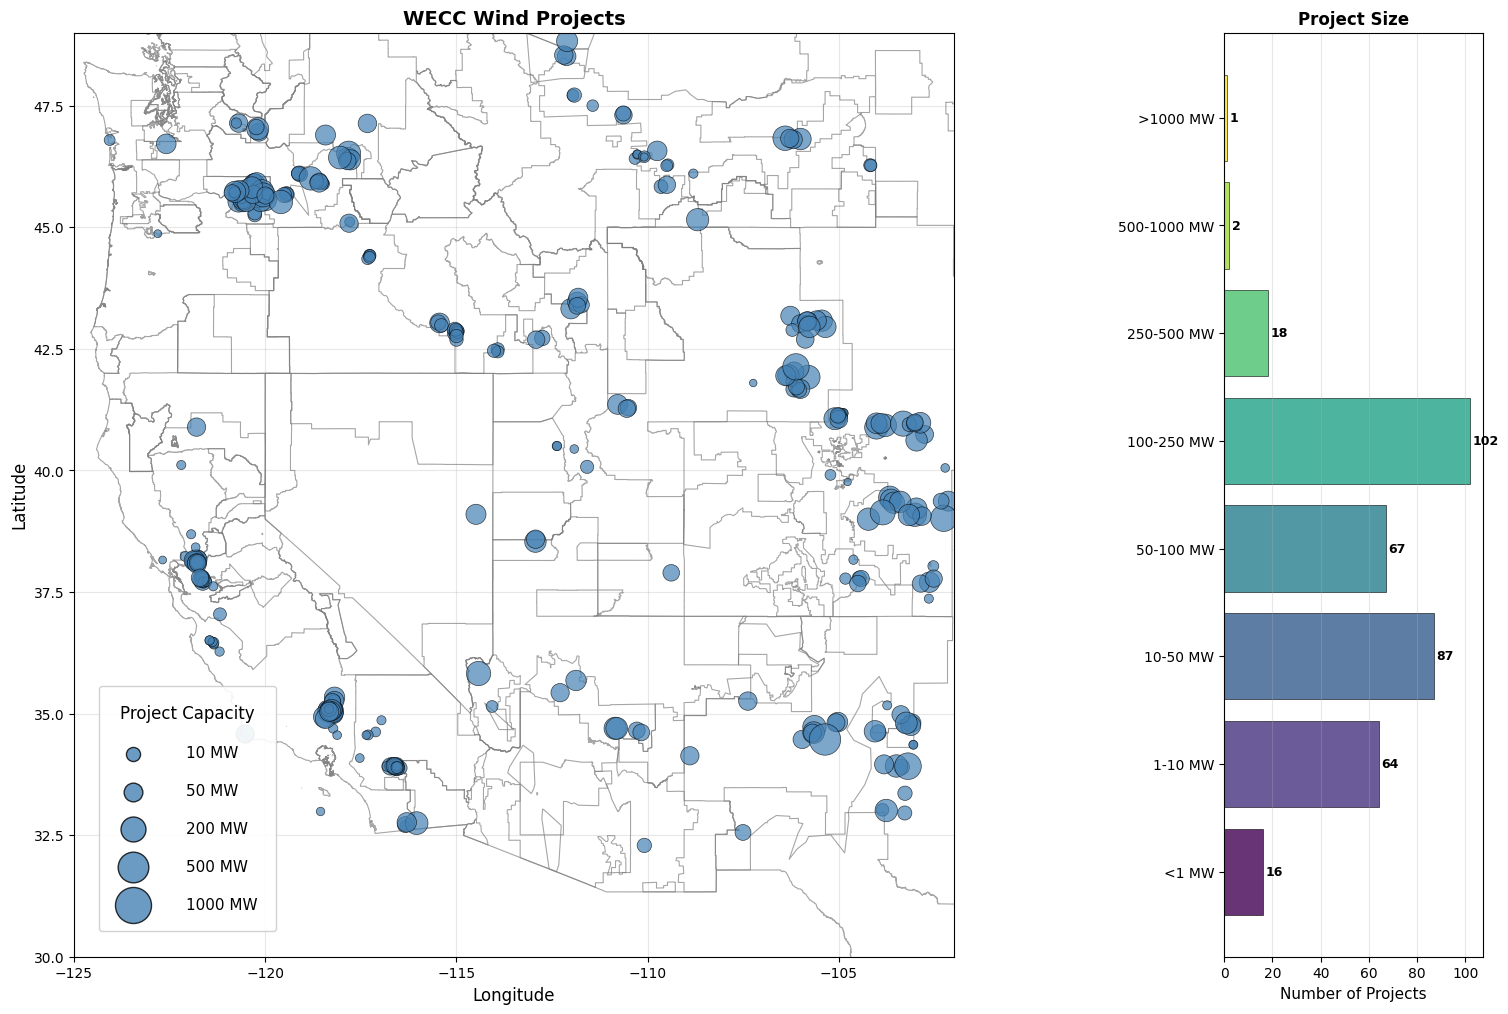

In [ ]:
def create_enhanced_wecc_visualization():
    """
    Create project-based bubble map showing wind facilities consolidated by project name
    """
    
    wecc_wind_mw = wecc_wind.copy()
    wecc_wind_mw['t_cap_mw'] = wecc_wind_mw['t_cap'] / 1000 # convert from kW to MW
    
    print(f"   • Total individual turbines: {len(wecc_wind_mw):,}")
    print(f"   • Unique projects: {wecc_wind_mw['p_name'].nunique():,}")
    
    # Consolidate turbines by project name (this creates the project-based bubbles)
    project_summary = wecc_wind_mw.groupby(['p_name']).agg({
        'xlong': 'mean',         
        'ylat': 'mean',
        't_cap_mw': 'sum',        # Total project capacity
        'case_id': 'count',       # Number of turbines in project
        't_state': 'first'        # State (assuming projects don't cross states)
    }).reset_index()
    
    project_summary.columns = ['project_name', 'longitude', 'latitude', 
                               'total_capacity_mw', 'turbine_count', 'state']
    
    significant_projects = project_summary.copy()

    fig = plt.figure(figsize=(20, 12))
    
    gs = fig.add_gridspec(1, 3, width_ratios=[2, 2, 1], hspace=0.3, wspace=0.3)
    ax_map = fig.add_subplot(gs[0, :2])  
    ax_bar = fig.add_subplot(gs[0, 2])   
    
    map_bounds = {'west': -125, 'east': -102, 'south': 30, 'north': 49}
    
    # Plot BA boundaries  
    wecc_ba_wgs84.boundary.plot(ax=ax_map, color='gray', linewidth=0.8, alpha=0.7)
    
    # bubbles
    max_project_capacity = significant_projects['total_capacity_mw'].max()
    min_project_capacity = significant_projects['total_capacity_mw'].min()
    bubble_sizes = np.sqrt(significant_projects['total_capacity_mw']) * 15 + 25
    
    bubble_color = 'steelblue' 
    scatter = ax_map.scatter(significant_projects['longitude'], significant_projects['latitude'],
                        s=bubble_sizes, c=bubble_color, alpha=0.7, 
                        edgecolors='black', linewidth=0.5, zorder=2)
    
    ax_map.set_xlim(map_bounds['west'], map_bounds['east'])
    ax_map.set_ylim(map_bounds['south'], map_bounds['north'])
    ax_map.set_xlabel('Longitude', fontsize=12)
    ax_map.set_ylabel('Latitude', fontsize=12)
    ax_map.set_title(f'WECC Wind Projects', 
                 fontweight='bold', fontsize=14)
    ax_map.grid(True, alpha=0.3)
    
    legend_capacities = [10, 50, 200, 500, 1000]
    legend_elements = []
    legend_labels = []
    
    for cap in legend_capacities:
        if cap <= max_project_capacity:
            legend_size = np.sqrt(cap) * 20 + 40  
            legend_elements.append(plt.scatter([], [], s=legend_size, c='steelblue', 
                                             edgecolors='black', alpha=0.8))
            legend_labels.append(f'{cap} MW')
    
    if legend_elements:
        bubble_legend = ax_map.legend(legend_elements, legend_labels, 
                                    title='Project Capacity', 
                                    loc='lower left', bbox_to_anchor=(0.02, 0.02), 
                                    fontsize=11, title_fontsize=12,  
                                    framealpha=0.9, fancybox=True, shadow=False,
                                    scatterpoints=1, markerscale=1.0,  
                                    columnspacing=2.0, handletextpad=2.5, 
                                    borderpad=1.2, labelspacing=1.5) 
        bubble_legend.set_zorder(1000)
    
    # project size categories
    size_bins = [0, 1, 10, 50, 100, 250, 500, 1000, float('inf')]
    size_labels = ['<1 MW', '1-10 MW', '10-50 MW', '50-100 MW', 
                   '100-250 MW', '250-500 MW', '500-1000 MW', '>1000 MW']
    
    # projects by size
    significant_projects['size_category'] = pd.cut(significant_projects['total_capacity_mw'], 
                                                  bins=size_bins, labels=size_labels, right=False)
    
    # projects in each category
    size_distribution = significant_projects['size_category'].value_counts().sort_index()
    
    bars = ax_bar.barh(range(len(size_distribution)), size_distribution.values, 
                       color=plt.cm.viridis(np.linspace(0, 1, len(size_distribution))),
                       alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax_bar.set_yticks(range(len(size_distribution)))
    ax_bar.set_yticklabels(size_distribution.index, fontsize=10)
    ax_bar.set_xlabel('Number of Projects', fontsize=11)
    ax_bar.set_title('Project Size', fontweight='bold', fontsize=12)
    ax_bar.grid(True, alpha=0.3, axis='x')
    
    for i, (bar, count) in enumerate(zip(bars, size_distribution.values)):
        if count > 0:
            ax_bar.text(count + max(size_distribution.values) * 0.01, i, str(count), 
                       va='center', ha='left', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    return fig, significant_projects, project_summary, size_distribution

fig, sig_projects, all_projects, size_dist = create_enhanced_wecc_visualization()
plt.show()